## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
!curl -L -o onegin.txt https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  256k  100  256k    0     0   380k      0 --:--:-- --:--:-- --:--:--  380k


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
token_to_idx = {ch: idx for idx, ch in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: ch for idx, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [40]:
# Your code here
import torch
import torch.nn as nn


device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)

class CharRNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.rnn_update = nn.Linear(emb_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.dropout = nn.Dropout(0.1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        h_next = self.dropout(h_next)

        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        return logits, h_next

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [42]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, encoded_text: torch.Tensor, seq_len=128, stride=128):
        self.data = encoded_text
        self.seq_len = seq_len
        self.stride = stride
        self.max_start = len(encoded_text) - (seq_len + 1)

    def __len__(self):
        return (self.max_start // self.stride) + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        chunk = self.data[start : start + self.seq_len + 1]
        x = chunk[:-1]  
        y = chunk[1:]
        return x, y

seq_len = 128
encoded = torch.tensor([token_to_idx[ch] for ch in text], dtype=torch.long)
ds = CharDataset(encoded, seq_len=seq_len, stride=seq_len) 
loader = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

x, y = next(iter(loader))
print(x.shape, y.shape) 

torch.Size([64, 128]) torch.Size([64, 128])


In [44]:
# Your plot code here
import torch.nn.functional as F


def rnn_loop(char_rnn, batch_x):
    batch_size, seq_len = batch_x.shape
    hid_state = char_rnn.initial_state(batch_size)
    logits = []
    
    for t in range(seq_len):
        x_t = batch_x[:, t] 
        logit_t, hid_state = char_rnn(x_t, hid_state)
        logits.append(logit_t)
        
    return torch.stack(logits, dim=1)

num_tokens = len(tokens)
char_rnn = CharRNN(num_tokens, emb_size=64, rnn_num_units=256)
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-3)
loss_hist = []

for epoch in range(100):
    total = 0.0
    for x, y in loader:
        opt.zero_grad()
        logits = rnn_loop(char_rnn, x)
        loss = F.cross_entropy(logits.reshape(-1, num_tokens), y.reshape(-1))

        loss.backward()
        opt.step()

        total += loss.item()

    avg_loss = total / len(loader)
    loss_hist.append(avg_loss)
    print(f"{(epoch+1):02d}: loss={(avg_loss):.4f}")




01: loss=3.6096
02: loss=3.0558
03: loss=2.8444
04: loss=2.6984
05: loss=2.6045
06: loss=2.5390
07: loss=2.4923
08: loss=2.4558
09: loss=2.4248
10: loss=2.3984
11: loss=2.3718
12: loss=2.3486
13: loss=2.3259
14: loss=2.3061
15: loss=2.2882
16: loss=2.2656
17: loss=2.2521
18: loss=2.2373
19: loss=2.2237
20: loss=2.2140
21: loss=2.2016
22: loss=2.1878
23: loss=2.1766
24: loss=2.1633
25: loss=2.1578
26: loss=2.1457
27: loss=2.1364
28: loss=2.1268
29: loss=2.1206
30: loss=2.1115
31: loss=2.1043
32: loss=2.0971
33: loss=2.0905
34: loss=2.0828
35: loss=2.0758
36: loss=2.0706
37: loss=2.0623
38: loss=2.0558
39: loss=2.0513
40: loss=2.0448
41: loss=2.0409
42: loss=2.0355
43: loss=2.0321
44: loss=2.0255
45: loss=2.0212
46: loss=2.0138
47: loss=2.0099
48: loss=2.0041
49: loss=2.0017
50: loss=1.9984
51: loss=1.9936
52: loss=1.9916
53: loss=1.9846
54: loss=1.9828
55: loss=1.9794
56: loss=1.9747
57: loss=1.9728
58: loss=1.9698
59: loss=1.9650
60: loss=1.9604
61: loss=1.9595
62: loss=1.9549
63: loss

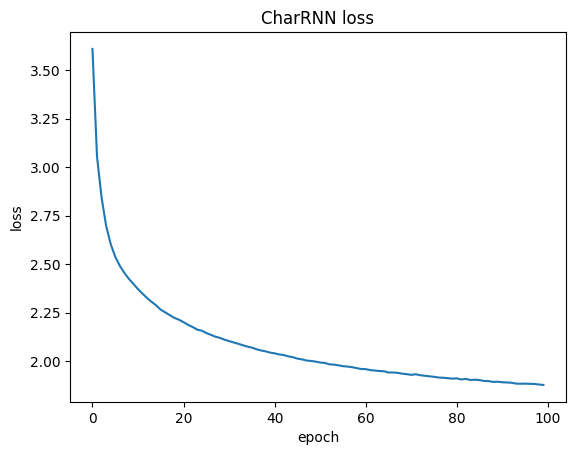

In [45]:
from matplotlib import pyplot as plt

def plot_history(hist, title=""):
    plt.plot(hist)
    plt.title(title + " loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")

plot_history(loss_hist, title="CharRNN")

In [46]:
import numpy as np
import torch
import torch.nn.functional as F

MAX_LENGTH = 1000

def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)  
    hid_state = char_rnn.initial_state(batch_size=1)            
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)  # x_sequence[:, i] имеет shape [1] -> ок
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)  # x_sequence[:, -1] имеет shape [1] -> ок
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])


In [ ]:
# An example of generated text.
print(generate_sample(char_rnn, "мой дядя", temperature=0.1))

мой дядя нет.



xxxii

как верельный страстить,
под он уж не вольно
в сердца согда сторова,
и вольной страстной странный,
и странный весной должна,
полодит и полова
порой не пред ней не зареда
после послет и веснова,
и ваш по мне постель
и крастительной душой,
и в тол должна в толодной,
как бертанье посладал не всег
довольно не поледный
и всё был полно и волненье
на стары всё был печаль вольной
в ней нет молчая простой,
не деревне странился он?
в сердце полные гостой
и в сердечной в семь и други



xxiii

в перед нам страстный в столо
в постель в своей следа своей,
и встарины последный взор,
всё том давно уставил
следан в сердце в гостин,
в сумана с волченный сона.



xxxii

как был полненье странной
вы в гостиный вольной
в своей полной старины
и так же татьяна своей,
в гладе всё в нем он поэта
и последний на старины
привычка он все подруг,
но всегда на шум нас не время,
в сердце в гостой своей
вот он не привычки молодый,
с ним сладой простала свой
в страстно девал свет сердце жена
и 

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [46]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)